# HAPPINESS
___

STAT 201 - Group 12: Anne Nguyen, Eric Pien, Oliver Gullery, Ruby Yang




## Introduction
___

Happiness can be said to be a subjective assessment of an individual’s emotion state/life satisfaction. Many factors can influence a person’s life satisfaction such as health, income, and social network. As a result, happiness can often act as an indicator for societal well-being. We aim to investigate how external events can affect this indicator, more specifically, the effects of the COVID-19 pandemic. Ultimately, we hope to answer the question: **Did Covid-19 impact levels of happiness**?

We will be using data from the *World Happiness Report (Helliwell et al., 2021)*. In the report, happiness score is assessed using the Cantril ladder – a tool used to measure a person’s subjective well-being. The score ranges from 0 to 10, representing the worst and the best possible life respectively. We will compare the `mean` and `standard deviation` in happiness score for years before and after the COVID-19 pandemic.  


## Preliminary Result ##
___

### Data Loading, Cleaning, Splitting ###

In [34]:
# Environment Setup
library(tidyverse)
library(tidymodels)
library(GGally)
library(gridExtra)
library(janitor)
library(cowplot)

options(repr.matrix.max.rows = 6) #limits output of dataframes to 6 rows

In [48]:
# Read data from the web into R
data <- read_csv('https://raw.githubusercontent.com/ericpien/stat-201-project/main/data/DataForTable2.1.csv',skip=0)

# Clean/Wrangle Data
happiness_data <- data |>
    clean_names() |>
    as_tibble() |>
    drop_na()

# Create n_tile clusters by the year
n_tile <- 4

happiness_data <- happiness_data |>
    group_by(year) |>
    mutate(life_ladder_ntile = ntile(-life_ladder,n_tile),
            log_gdp_per_capita_ntile = ntile(-log_gdp_per_capita,n_tile),
            social_support_ntile = ntile(-social_support,n_tile),
            healthy_life_expectancy_at_birth_ntile = ntile(-healthy_life_expectancy_at_birth,n_tile),
            freedom_to_make_life_choices_ntile = ntile(-freedom_to_make_life_choices,n_tile),
            generosity_ntile = ntile(-generosity,n_tile),
            perceptions_of_corruption_ntile = ntile(-perceptions_of_corruption,n_tile),
            positive_affect_ntile = ntile(-positive_affect,n_tile),
            negative_affect_ntile = ntile(-negative_affect,n_tile),
            confidence_in_national_government_ntile = ntile(-confidence_in_national_government,n_tile))

# Create wide dataframe of mean happiness
happiness_data_wide_life_ladder <- happiness_data |> 
    group_by(country_name,year) |>
    summarize(life_ladder = life_ladder) |>
    pivot_wider(names_from = year,
                values_from = life_ladder)

Rows: 2089 Columns: 12
-- Column specification --------------------------------------------------------
Delimiter: ","
chr  (1): Country name
dbl (11): year, Life Ladder, Log GDP per capita, Social support, Healthy lif...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'country_name'. You can override using the
`.groups` argument.


### Preliminary Data Exploration ###

In [74]:
# Number of countries and available data
options(repr.plot.width = 15, repr.plot.height = 15) 

happiness_data_obs <- happiness_data |> 
    group_by(country_name) |> 
    summarize(obs_count=n(),
                mean_cluster = as.integer(mean(life_ladder_ntile))) |>
    arrange(-obs_count) |>
    ggplot(aes(x=obs_count,y=fct_inorder(country_name),fill = factor(mean_cluster))) +
    geom_col() +
    scale_fill_brewer(palette="Set3") +
    labs(x="# of Observations", y="Country", fill="Mean Life Ladder n tile", title="Number of Countries and Available Observations", caption = "Figure 1")

#happiness_data_obs # Chart displayed as a group below

# YoY happiness metric heatmap
happiness_heatmap <- happiness_data_wide_life_ladder |>
    pivot_longer(cols=-country_name,names_to="year",values_to ="life_ladder") |>
    ggplot(aes(x=year, y=country_name)) +
    geom_tile(aes(fill=life_ladder), color="black") +
    scale_fill_gradient(low="white", high="#1818ff") +
    labs(x="Year", y="Country", fill="Happiness", title="YoY Happiness by Country", caption = "Figure 2")

#happiness_heatmap # Chart displayed as a group below

### 2019, 2020, 2021 Data ###

In [140]:
# Create a list of countries that have data for 2019 and 2021
country_name_2019_2021  <- happiness_data |>
    group_by(country_name) |>
    filter(year %in% c(2019,2021)) |>
    drop_na() |>
    summarise(n=n()) |>
    filter(n>1) |>
    pull(country_name)

# Select the countries and filter for 2019 and 2021 data
happiness_data_2019_2021 <- happiness_data |>
    filter(country_name %in% country_name_2019_2021,
            year %in% c(2019,2021))

# Summarize the estimates of the parameters (mean and sd) across the groups (2019 and 2021)
happiness_data_2019_2021 |> group_by(year) |> summarise(mean_happiness = mean(life_ladder), sd = sd(life_ladder))

year,mean_happiness,sd
<dbl>,<dbl>,<dbl>
2019,5.737087,1.089441
2021,5.670313,1.138531


In [131]:
# Change from 2019, 2020, and 2021 happiness
options(repr.plot.width = 10, repr.plot.height = 10)

happiness_trail <- happiness_data_wide_life_ladder |> select(country_name,`2019`,`2020`,`2021`) |> drop_na() |> pivot_longer(cols=-country_name,names_to="year",values_to ="life_ladder") |> mutate(year = as.integer(year)) |>
    ggplot(aes(x=year, y=life_ladder, group=country_name, color=country_name)) +
    geom_line() +
    geom_text(aes(label = country_name)) +
    theme(legend.position="none") +
    labs(x="Year",y="Life Ladder",title="Happiness from 2019 to 2021", caption = "Figure 3") + 
    scale_x_continuous(breaks=c(2019,2020,2021), limits = c(2019,2021))
    
# happiness_trail # Chart displayed as a group below

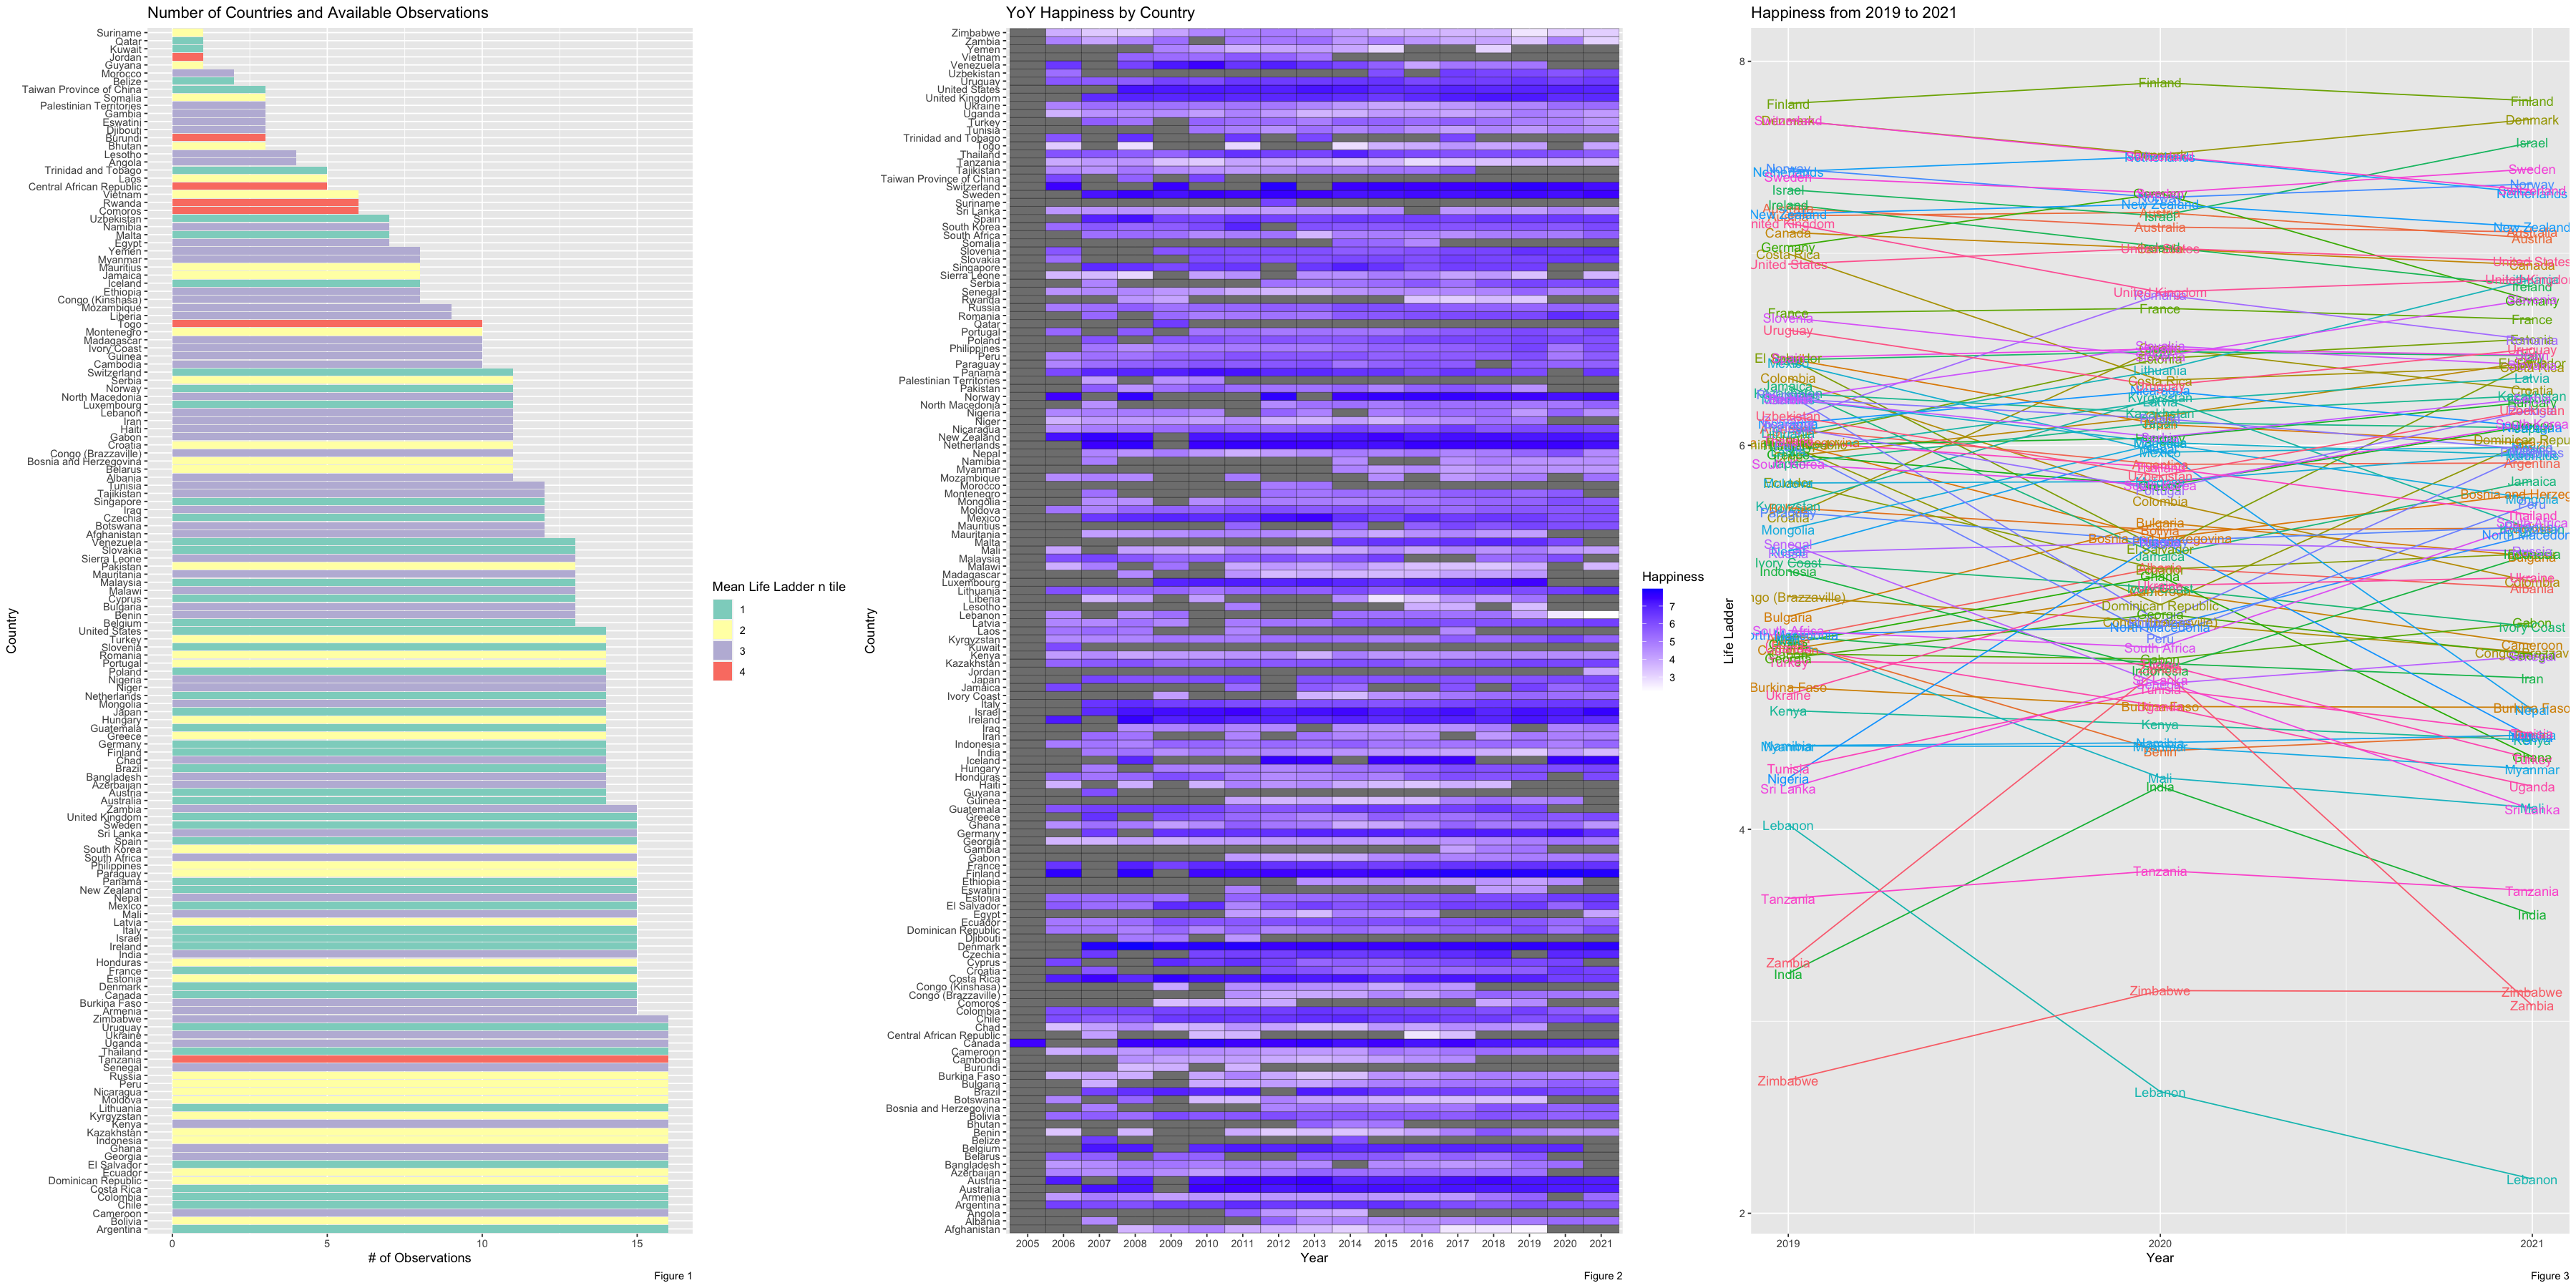

In [132]:
# Summary of all charts made thus far
options(repr.plot.width = 30, repr.plot.height = 15)
plot_grid(happiness_data_obs,happiness_heatmap,happiness_trail, ncol = 3)

[1] -0.06677416

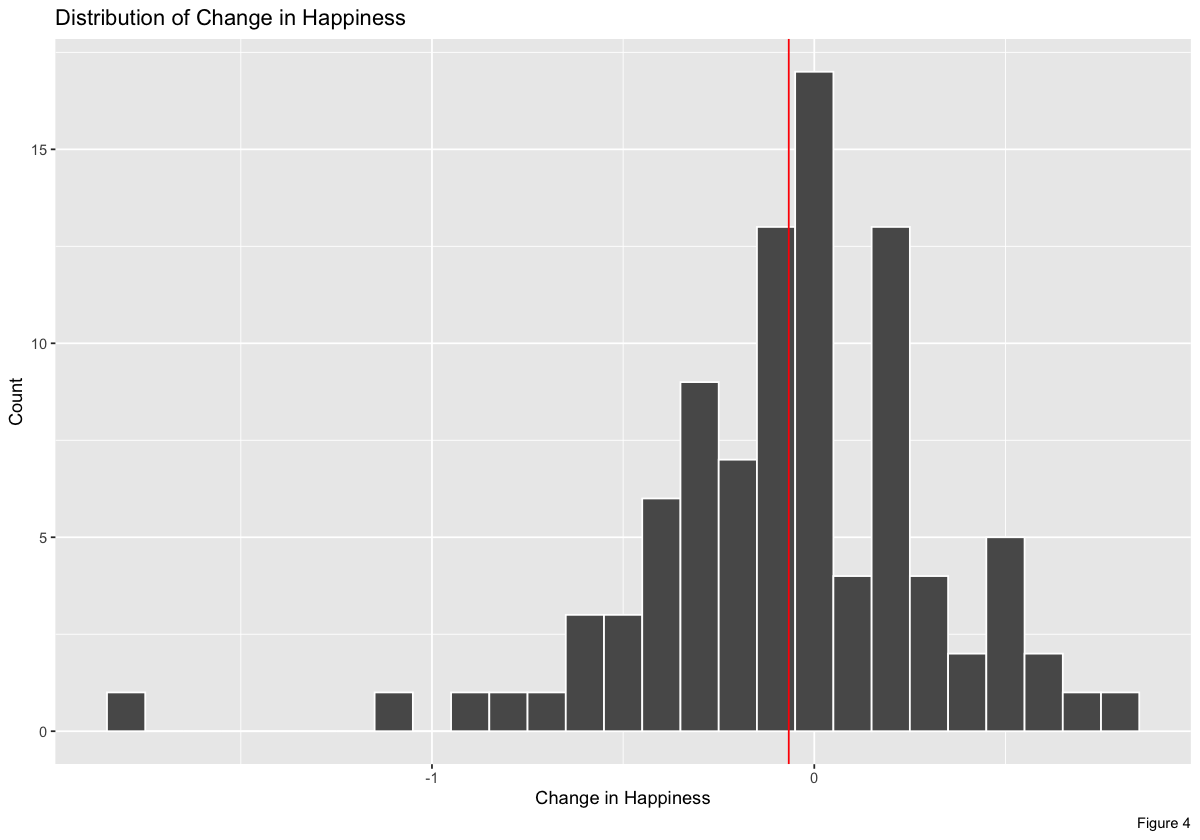

In [78]:
# Change Mean from 2021 to 2019
change_2019_2021 <- happiness_data_wide_life_ladder |>
    select(country_name,`2019`,`2021`) |>
    drop_na() |>
    group_by(country_name) |>
    mutate(change = `2021`-`2019`)

# Mean Change
mean(change_2019_2021$change)

# Plot the Distribution
options(repr.plot.width = 10, repr.plot.height = 7) 
change_2019_2021 |>
    ggplot(aes(x=change)) +
    geom_histogram(binwidth = 0.1, color="white") +
    geom_vline(xintercept=mean(change_2019_2021$change),color="red") +
    labs(x="Change in Happiness",y="Count",title="Distribution of Change in Happiness", caption = "Figure 4")

## Methods
___

**The Good**  
Both the calculated mean change in Happiness and Figure 4 shows that the majority of countries did not observe a mean change in happiness greater than 1. The report is trustworthy since the data is collected by researchers who have continuously surveyed the world for 9 years, the report's source is also reliable and up-to-date.

**The Bad**
While the aforementioned figures provide a good understanding of the mean change in happiness, this is insufficient to report to a stakeholder because we did not report any measures of uncertainty due to variance with our estimate. Furthermore, from the perspective of a stakeholder, it may be best to narrow the countries based on their geographical regions. We can see in the distribution that there are outliers whose happiness has been greatly and negatively impacted compared to the rest of the world. Lastly, COVID-19 is an ongoing pandemic and each country's situation is different so our measures of before and after may not be applicable to all countries. For the sake of the report, 2019 will be "before COVID-19" and 2021 will be "after COVID-19".

**The Solution**
To include measures of certainty, we will perform hypothesis testing and calculate a confidence interval for the mean change in happiness between 2019 and 2021. This allows for a statistical measure of uncertainty in our report.

The two samples are dependent as they survey the same countries, we will perform a paired t-test.


Our hypotheses are the following:  
$$
\begin{align*}
H_0&: \mu_{\text{2021}} - \mu_{\text{2019}} = 0 \qquad \text{(Null Hypothesis: There is no change in mean Happiness before and after COVID-19 throughout countries in the world.)} \\ 
H_1&: \mu_{\text{2021}} - \mu_{\text{2019}} \neq 0 \qquad \text{(Alternative Hypothesis: There is a change in mean Happiness throughout countries in the world)} \\ 
\end{align*}
$$

The significance level will be 0.05 to reasonably reduce the risk of committing a type II error as ignoring the effects of COVID-19 may have greater consequences.

The corresponding confidence level of the confidence interval will be 95% (derived from 1- $\alpha$).

**What do you expect to find?**

We expect that COVID-19 decreased happiness levels. We would attribute this to the effects of lockdown; studies done on the effects of vitamin D deficiency (caused due to lack of sunlight) found that it would lead to issues such as depression (Anjum et al., 2018). Staying indoors has been shown to have similar effects (Thakur et al., 2020). This data suggests that COVID would decrease happiness levels. 


**What impact could such findings have?**

As previously mentioned, happiness is a subjective assessment of an individual’s emotional state or of their life satisfaction. As a result, we believe it is an important metric that could be used to assess government policies. In the case of COVID, utilising happiness as a factor to assess certain policies may have helped the government adjust these policies to the benefit of social welfare. Our findings which assess happiness levels during COVID-19 could be extrapolated to find small shifts in happiness in accordance with certain policies or events - ultimately leading to the ability of happiness to be used as a metric for decision-making (Musikanski, 2014).

**What future questions could this lead to?**
* How do countries with different pandemic responses and policies compare in terms of changes in happiness levels?

* How does happiness relate to other indicators of success, such as GDP, and should it be given greater consideration in policymaking?


## TODO:
* "compare both the bootstrapping and asymptotic methods"
    
    

## References
___

Anjum, I., Jaffery, S. S., Fayyaz, M., Samoo, Z., Anjum, S., Anjum, I., Jaffery, S. S., Fayyaz, M., Samoo, Z., & Anjum, S. (2018). The role of vitamin d in brain health: A mini literature review. Cureus, 10(7). https://doi.org/10.7759/cureus.2960

Helliwell, J. F., Layard, R., Sachs, J. D., Neve, J.-E. D., Aknin, L. B., & Wang, S. (2021, March 20). World happiness report 2021. https://worldhappiness.report/ed/2021/

Musikanski, L. (2014). Happiness in public policy. Journal of Sustainable Social Change, 6(1). https://scholarworks.waldenu.edu/jsc/vol6/iss1/5

Thakur, K., Kumar, N., & Sharma, N. (2020). Effect of the pandemic and lockdown on mental health of children. The Indian Journal of Pediatrics, 87(7), 552–552. https://doi.org/10.1007/s12098-020-03308-w
